In [11]:
import itertools
import random as rd
from matplotlib.patches import Circle
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import numpy as np
from ortools.sat.python import cp_model

# Smallest Container Problem

The smallest container problem is a classic problem in computational geometry and optimization. It's concerned with finding the smallest possible container that can hold a given set of items or objects. The problem can be framed in different contexts depending on the type of items and containers involved. 

We will consider $n$ = 10 circles of random radii $(r_{i})$ within the interval $[1,m]$ to determine the smallest square of length $S$.

Note: Becuase this solution uses CP, we are only capable of providing integer solutions for x,y coordinates of each circle. Continuous x,y coordinates will extend the state space and provide optimal solutions but will also increase the solve time. 

<!-- A possible workaround would be to scale the radii and coordinates by a factor of $10^x$ when finding a solution, and then rescaling the values when plotting the solution. -->

In [12]:
rd.seed(12345)

n = 10
m = 7

r = [rd.randint(1,7) for i in range(n)]

combin = list(itertools.combinations(range(n),2))

model = cp_model.CpModel()
solver = cp_model.CpSolver()

x = {i: model.NewIntVar(1,sum(r), f'x_{i}') for i in range(n)}
y = {i: model.NewIntVar(1,sum(r), f'y_{i}') for i in range(n)}

x_dif = {(i,j): model.NewIntVar(-int(sum(r)**2),int(sum(r)**2), f'x_dif_{i}_{j}') for i,j in combin}
y_dif = {(i,j): model.NewIntVar(-int(sum(r)**2),int(sum(r)**2), f'y_dif_{i}_{j}') for i,j in combin}

x2 = {(i,j): model.NewIntVar(1,int(sum(r)**2), f'x2_{i}_{j}') for i,j in combin}
y2 = {(i,j): model.NewIntVar(1,int(sum(r)**2), f'y2_{i}_{j}') for i,j in combin}

S = model.NewIntVar(1,sum(r), f'S')

for i,j in combin:
    model.Add(x_dif[i,j] == x[i] - x[j])
    model.Add(y_dif[i,j] == y[i] - y[j])

    model.AddMultiplicationEquality(x2[i,j], x_dif[i,j], x_dif[i,j])
    model.AddMultiplicationEquality(y2[i,j], y_dif[i,j], y_dif[i,j])

    model.Add(x2[i,j] + y2[i,j] >= int((r[i] + r[j])**2))

for i in range(n):
    model.Add(x[i] >= r[i])
    model.Add(x[i] + r[i] <= S)

    model.Add(y[i] >= r[i])
    model.Add(y[i] + r[i] <= S)

model.Minimize(S)

status = solver.Solve(model)
print(f'Status = {solver.StatusName(status)}')

Status = OPTIMAL


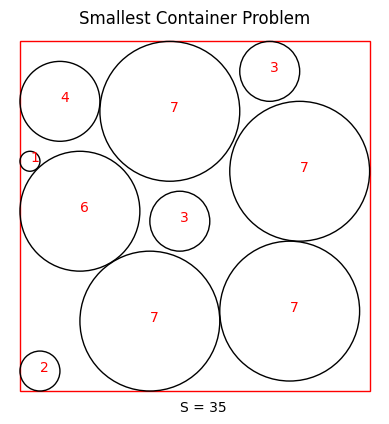

In [13]:
fig, ax = plt.subplots()

circles = [(solver.value(x[i]), solver.value(y[i])) for i in range(n)]

for i in range(n):
    cir = plt.Circle(circles[i], r[i], color = 'k', fill= False, zorder = 3)
    ax.set_aspect('equal', adjustable='box')
    ax.add_patch(cir)
    ax.text(circles[i][0], circles[i][1], r[i], color = 'r')

square = plt.Rectangle((0,0), solver.value(S), solver.value(S), edgecolor = 'r', fill = False)
ax.add_patch(square)
ax.text(solver.value(S)/2-1.5, -2, f'S = {solver.value(S)}')

ax.set_xbound(lower = -1, upper = solver.value(S)+1)
ax.set_ybound(lower = -1, upper = solver.value(S)+1)

plt.title('Smallest Container Problem')
plt.axis('off')
plt.show()